# Gaussian process prior samples

*You are seeing the
notebook output generated by
[Literate.jl](https://github.com/fredrikekre/Literate.jl) from the
[Julia source file](https://github.com/JuliaGaussianProcesses/KernelFunctions.jl/blob/master/examples/gaussian-process-priors/script.jl).
The rendered HTML can be viewed [in the docs](https://juliagaussianprocesses.github.io/KernelFunctions.jl/dev/examples/gaussian-process-priors/).*

The kernels defined in this package can also be used to specify the
covariance of a Gaussian process prior.
A Gaussian process (GP) is defined by its mean function $m(\cdot)$ and its covariance function or kernel $k(\cdot, \cdot')$:
$$
  f \sim \mathcal{GP}\big(m(\cdot), k(\cdot, \cdot')\big)
$$
In this notebook we show how the choice of kernel affects the samples from a GP (with zero mean).

In [1]:
# Load required packages
using KernelFunctions, LinearAlgebra
using Plots, Plots.PlotMeasures
default(; lw=1.0, legendfontsize=8.0)
using Random: seed!
seed!(42); # reproducibility

## Evaluation at finite set of points

The function values $\mathbf{f} = \{f(x_n)\}_{n=1}^N$ of the GP at a finite number $N$ of points $X = \{x_n\}_{n=1}^N$ follow a multivariate normal distribution $\mathbf{f} \sim \mathcal{MVN}(\mathbf{m}, \mathrm{K})$ with mean vector $\mathbf{m}$ and covariance matrix $\mathrm{K}$, where
$$
\begin{aligned}
  \mathbf{m}_i &= m(x_i) \\
  \mathrm{K}_{i,j} &= k(x_i, x_j)
\end{aligned}
$$
with $1 \le i, j \le N$.

We can visualize the infinite-dimensional GP by evaluating it on a fine grid to approximate the dense real line:

In [2]:
num_inputs = 101
xlim = (-5, 5)
X = range(xlim...; length=num_inputs);

Given a kernel `k`, we can compute the kernel matrix as `K = kernelmatrix(k, X)`.

## Random samples

To sample from the multivariate normal distribution $p(\mathbf{f}) = \mathcal{MVN}(0, \mathrm{K})$, we could make use of Distributions.jl and call `rand(MvNormal(K))`.
Alternatively, we could use the [AbstractGPs.jl](https://github.com/JuliaGaussianProcesses/AbstractGPs.jl) package and construct a `GP` object which we evaluate at the points of interest and from which we can then sample: `rand(GP(k)(X))`.

Here, we will explicitly construct samples using the Cholesky factorization $\mathrm{L} = \operatorname{cholesky}(\mathrm{K})$,
with $\mathbf{f} = \mathrm{L} \mathbf{v}$, where $\mathbf{v} \sim \mathcal{N}(0, \mathbf{I})$ is a vector of standard-normal random variables.

We will use the same randomness $\mathbf{v}$ to generate comparable samples across different kernels.

In [3]:
num_samples = 7
v = randn(num_inputs, num_samples);

Mathematically, a kernel matrix is by definition positive semi-definite, but due to finite-precision inaccuracies, the computed kernel matrix might not be exactly positive definite. To avoid Cholesky errors, we add a small "nugget" term on the diagonal:

In [4]:
function mvn_sample(K)
    L = cholesky(K + 1e-6 * I)
    f = L.L * v
    return f
end;

## Visualization
We now define a function that visualizes a kernel for us.

In [5]:
function visualize(k::Kernel)
    K = kernelmatrix(k, X)
    f = mvn_sample(K)

    p_kernel_2d = heatmap(
        X,
        X,
        K;
        yflip=true,
        colorbar=false,
        ylabel=string(nameof(typeof(k))),
        ylim=xlim,
        yticks=([xlim[1], 0, xlim[end]], ["\u22125", raw"$x'$", "5"]),
        vlim=(0, 1),
        title=raw"$k(x, x')$",
        aspect_ratio=:equal,
        left_margin=5mm,
    )

    p_kernel_cut = plot(
        X,
        k.(X, 0.0);
        title=string(raw"$k(x, x_\mathrm{ref})$"),
        label=raw"$x_\mathrm{ref}=0.0$",
        legend=:topleft,
        foreground_color_legend=nothing,
    )
    plot!(X, k.(X, 1.5); label=raw"$x_\mathrm{ref}=1.5$")

    p_samples = plot(X, f; c="blue", title=raw"$f(x)$", ylim=(-3, 3), label=nothing)

    return plot(
        p_kernel_2d,
        p_kernel_cut,
        p_samples;
        layout=(1, 3),
        xlabel=raw"$x$",
        xlim=xlim,
        xticks=collect(xlim),
    )
end;

We can now visualize a kernel and show samples from
a Gaussian process with a given kernel:

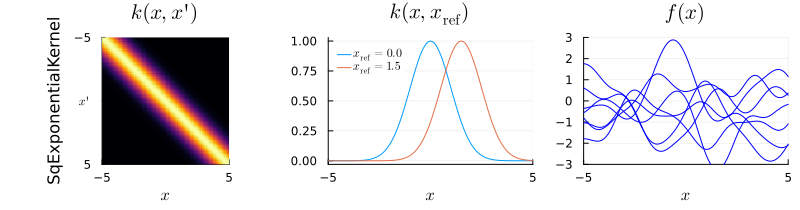

In [6]:
plot(visualize(SqExponentialKernel()); size=(800, 210), bottommargin=5mm, topmargin=5mm)

## Kernel comparison
This also allows us to compare different kernels:

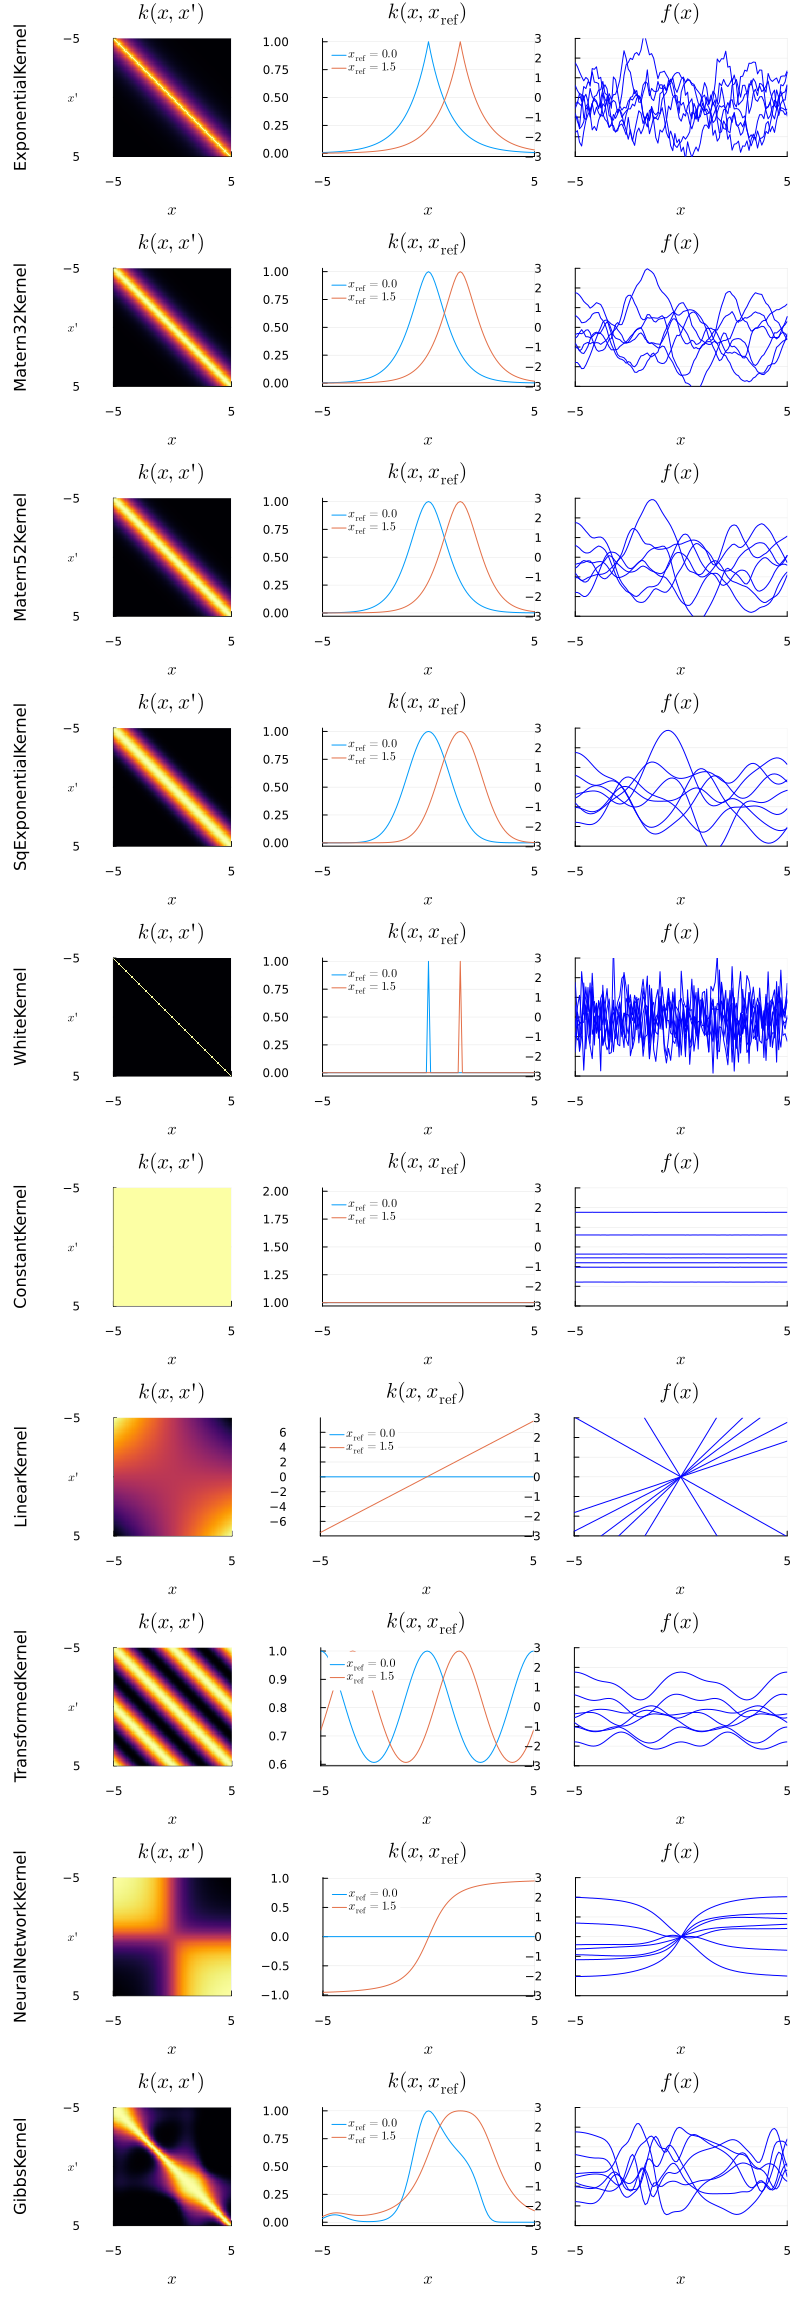

In [7]:
kernels = [
    Matern12Kernel(),
    Matern32Kernel(),
    Matern52Kernel(),
    SqExponentialKernel(),
    WhiteKernel(),
    ConstantKernel(),
    LinearKernel(),
    compose(PeriodicKernel(), ScaleTransform(0.2)),
    NeuralNetworkKernel(),
    GibbsKernel(; lengthscale=x -> sum(exp ∘ sin, x)),
]
plot(
    [visualize(k) for k in kernels]...;
    layout=(length(kernels), 1),
    size=(800, 220 * length(kernels) + 100),
)

<hr />
<h6>Package and system information</h6>
<details>
<summary>Package information (click to expand)</summary>
<pre>
Status &#96;~/work/KernelFunctions.jl/KernelFunctions.jl/examples/gaussian-process-priors/Project.toml&#96;
  &#91;31c24e10&#93; Distributions v0.25.122
  &#91;ec8451be&#93; KernelFunctions v0.10.66 &#96;/home/runner/work/KernelFunctions.jl/KernelFunctions.jl#823219b&#96;
  &#91;98b081ad&#93; Literate v2.20.1
  &#91;91a5bcdd&#93; Plots v1.41.1
  &#91;37e2e46d&#93; LinearAlgebra v1.12.0
  &#91;9a3f8284&#93; Random v1.11.0
</pre>
To reproduce this notebook's package environment, you can
<a href="./Manifest.toml">
download the full Manifest.toml</a>.
</details>
<details>
<summary>System information (click to expand)</summary>
<pre>
Julia Version 1.12.0
Commit b907bd0600f &#40;2025-10-07 15:42 UTC&#41;
Build Info:
  Official https://julialang.org release
Platform Info:
  OS: Linux &#40;x86_64-linux-gnu&#41;
  CPU: 4 × AMD EPYC 7763 64-Core Processor
  WORD_SIZE: 64
  LLVM: libLLVM-18.1.7 &#40;ORCJIT, znver3&#41;
  GC: Built with stock GC
Threads: 1 default, 1 interactive, 1 GC &#40;on 4 virtual cores&#41;
Environment:
  JULIA_DEBUG &#61; Documenter
  JULIA_LOAD_PATH &#61; :/home/runner/.julia/packages/JuliaGPsDocs/7M86H/src
</pre>
</details>

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*